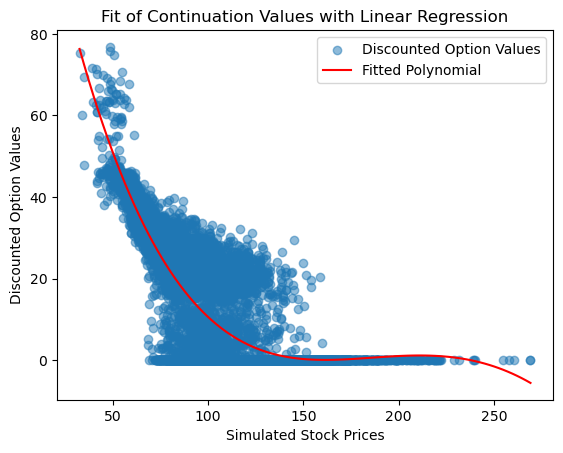

Initial Stock Price: 100, Volatility: 0.4, Maturity: 1
Simulated American (MC) Price using Linear Regression: 14.3928, Standard Error: 0.1414, Time: 3.1247s


In [133]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import eval_laguerre
from math import exp, sqrt
import time
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings("ignore")

# Function to generate paths for the underlying asset
def paths(S0, K, T, r, sigma, M, I):
    dt = T / M
    S = np.zeros((I, M + 1))
    S[:, 0] = S0
    for t in range(1, M + 1):
        z = np.random.standard_normal(I)
        S[:, t] = S[:, t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * sqrt(dt) * z)
    return S

# Function to calculate the payoff of the option
def payoff(S, K):
    return np.maximum(K - S, 0)

# Function to calculate the discount factor
def discount_factor(r, t1, t0):
    return exp(-r * (t1 - t0))

# Longstaff-Schwartz algorithm for pricing American options using Linear Regression with polynomial features
def longstaff_schwartz_linreg(S, K, T, r, sigma, n_steps, n_paths, n_order, plot_step=None):
    dt = T / n_steps
    V = np.zeros_like(S)

    # Step 2: Set prices at maturity to the payoff
    V[:, -1] = payoff(S[:, -1], K)

    # Steps 3-8: Iterate backwards in time
    for i in range(n_steps - 1, 0, -1):
        discount = discount_factor(r, (i + 1) * dt, i * dt)
        X = S[:, i].reshape(-1, 1)
        Y = discount * V[:, i + 1]

        # Step 6a: Fit Linear Regression model with polynomial features
        poly = PolynomialFeatures(degree=n_order - 1)
        X_poly = poly.fit_transform(X)
        linreg_model = LinearRegression()
        linreg_model.fit(X_poly, Y)
        continuation_values = linreg_model.predict(X_poly)

        # Step 7: Exercise if immediate payoff is greater than continuation value
        immediate_payoff = payoff(S[:, i], K)
        V[:, i] = np.where(immediate_payoff > continuation_values, immediate_payoff, discount * V[:, i + 1])

        # Plot the fit at the specified time step
        if plot_step and i == plot_step:
            #plt.figure(figsize=(10, 6))
            plt.scatter(S[:, i], Y, label='Discounted Option Values', alpha=0.5)
            #plt.plot(S[:, i], continuation_values, 'r.', color='blue', label='Linear Regression Continuation Values', alpha=0.5)
            
            fitted = np.polynomial.Polynomial.fit(S[:, i], Y, n_order - 1)
            plt.plot(*fitted.linspace(), color='red', label="Fitted Polynomial")

            plt.xlabel('Simulated Stock Prices')
            plt.ylabel('Discounted Option Values')
            plt.title('Fit of Continuation Values with Linear Regression')
            plt.legend()
            #plt.grid(True)
            #plt.savefig(f'fit_plot_step_{plot_step}.png')
            plt.show()

    # Step 9-10: Calculate price today
    discounted_V = discount_factor(r, dt, 0) * V[:, 1]
    price_today = np.mean(discounted_V)
    standard_error = np.std(discounted_V) / sqrt(n_paths)
    
    return price_today, standard_error

# Parameters
K = 100  # Strike price
r = 0.02  # Risk-free interest rate
T = 1  # Time to expiration
S0 = 100  # Initial stock price
sigma = 0.4  # Volatility value
n_paths = 10000  # Number of paths
n_steps = 50  # Number of exercise points per year
n_order = 5  # Number of basis functions
plot_step = 25  # Specific time step to plot

start_time = time.time()
S = paths(S0, K, T, r, sigma, n_steps, n_paths)
price, std_err = longstaff_schwartz_linreg(S, K, T, r, sigma, n_steps, n_paths, n_order, plot_step=plot_step)
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Initial Stock Price: {S0}, Volatility: {sigma}, Maturity: {T}")
print(f"Simulated American (MC) Price using Linear Regression: {price:.4f}, Standard Error: {std_err:.4f}, Time: {elapsed_time:.4f}s")


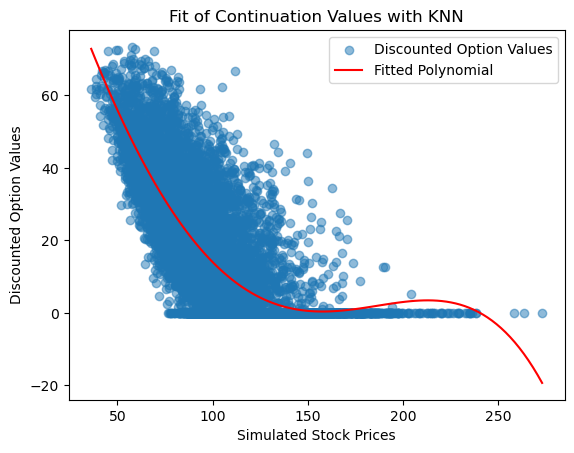

Initial Stock Price: 100, Volatility: 0.4, Maturity: 1
Simulated American (MC) Price using KNN: 18.8414, Standard Error: 0.1617, Time: 2.5938s


In [134]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import eval_laguerre
from math import exp, sqrt
import time
from sklearn.neighbors import KNeighborsRegressor
import warnings
warnings.filterwarnings("ignore")

# Function to generate paths for the underlying asset
def paths(S0, K, T, r, sigma, M, I):
    dt = T / M
    S = np.zeros((I, M + 1))
    S[:, 0] = S0
    for t in range(1, M + 1):
        z = np.random.standard_normal(I)
        S[:, t] = S[:, t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * sqrt(dt) * z)
    return S

# Function to calculate the payoff of the option
def payoff(S, K):
    return np.maximum(K - S, 0)

# Function to calculate the discount factor
def discount_factor(r, t1, t0):
    return exp(-r * (t1 - t0))

# Longstaff-Schwartz algorithm for pricing American options using KNN regression
def longstaff_schwartz_knn(S, K, T, r, sigma, n_steps, n_paths, n_neighbors, n_order, plot_step=None):
    dt = T / n_steps
    V = np.zeros_like(S)

    # Step 2: Set prices at maturity to the payoff
    V[:, -1] = payoff(S[:, -1], K)

    # Steps 3-8: Iterate backwards in time
    for i in range(n_steps - 1, 0, -1):
        discount = discount_factor(r, (i + 1) * dt, i * dt)
        X = S[:, i].reshape(-1, 1)
        Y = discount * V[:, i + 1]

        # Step 6a: Fit KNN regression model
        knn_model = KNeighborsRegressor(n_neighbors=n_neighbors)
        knn_model.fit(X, Y)
        continuation_values = knn_model.predict(X)

        # Step 7: Exercise if immediate payoff is greater than continuation value
        immediate_payoff = payoff(S[:, i], K)
        V[:, i] = np.where(immediate_payoff > continuation_values, immediate_payoff, discount * V[:, i + 1])

        # Plot the fit at the specified time step
        if plot_step and i == plot_step:
            #plt.figure(figsize=(8, 5))
            plt.scatter(S[:, i], Y, label='Discounted Option Values', alpha=0.5)
            #plt.plot(S[:, i], continuation_values, 'r.', color='blue', label='KNN Continuation Values', alpha=0.5)

            fitted = np.polynomial.Polynomial.fit(S[:, i], Y, n_order - 1)
            plt.plot(*fitted.linspace(), color='red', label="Fitted Polynomial")

            plt.xlabel('Simulated Stock Prices')
            plt.ylabel('Discounted Option Values')
            plt.title('Fit of Continuation Values with KNN')
            plt.legend()
            #plt.grid(True)
            #plt.savefig(f'fit_plot_step_{plot_step}.png')
            plt.show()

    # Step 9-10: Calculate price today
    discounted_V = discount_factor(r, dt, 0) * V[:, 1]
    price_today = np.mean(discounted_V)
    standard_error = np.std(discounted_V) / sqrt(n_paths)

    return price_today, standard_error

# Parameters
K = 100  # Strike price
r = 0.02  # Risk-free interest rate
T = 1  # Time to expiration
S0 = 100  # Initial stock price
sigma = 0.4  # Volatility value
n_paths = 10000  # Number of paths
n_steps = 50  # Number of exercise points per year
n_order = 5  # Number of basis functions
plot_step = 25  # Specific time step to plot
n_neighbors = 5  # Number of neighbors for KNN regression

start_time = time.time()
S = paths(S0, K, T, r, sigma, n_steps, n_paths)
price, std_err = longstaff_schwartz_knn(S, K, T, r, sigma, n_steps, n_paths, n_neighbors, n_order, plot_step=plot_step)
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Initial Stock Price: {S0}, Volatility: {sigma}, Maturity: {T}")
print(f"Simulated American (MC) Price using KNN: {price:.4f}, Standard Error: {std_err:.4f}, Time: {elapsed_time:.4f}s")


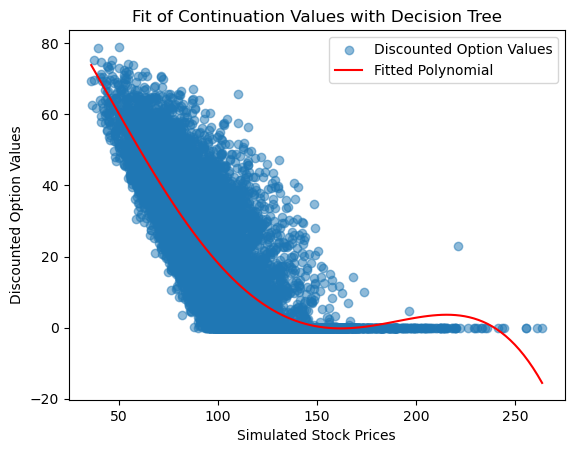

Initial Stock Price: 100, Volatility: 0.4, Maturity: 1
Simulated American (MC) Price using Decision Tree: 24.5571, Standard Error: 0.1670, Time: 2.0336s


In [135]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import eval_laguerre
from math import exp, sqrt
import time
from sklearn.tree import DecisionTreeRegressor
import warnings
warnings.filterwarnings("ignore")

# Function to generate paths for the underlying asset
def paths(S0, K, T, r, sigma, M, I):
    dt = T / M
    S = np.zeros((I, M + 1))
    S[:, 0] = S0
    for t in range(1, M + 1):
        z = np.random.standard_normal(I)
        S[:, t] = S[:, t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * sqrt(dt) * z)
    return S

# Function to calculate the payoff of the option
def payoff(S, K):
    return np.maximum(K - S, 0)

# Function to calculate the discount factor
def discount_factor(r, t1, t0):
    return exp(-r * (t1 - t0))

# Longstaff-Schwartz algorithm for pricing American options using Decision Tree regression
def longstaff_schwartz_dtree(S, K, T, r, sigma, n_steps, n_paths, n_order, plot_step=None):
    dt = T / n_steps
    V = np.zeros_like(S)

    # Step 2: Set prices at maturity to the payoff
    V[:, -1] = payoff(S[:, -1], K)

    # Steps 3-8: Iterate backwards in time
    for i in range(n_steps - 1, 0, -1):
        discount = discount_factor(r, (i + 1) * dt, i * dt)
        X = S[:, i].reshape(-1, 1)
        Y = discount * V[:, i + 1]

        # Step 6a: Fit Decision Tree regression model
        dtree_model = DecisionTreeRegressor()
        dtree_model.fit(X, Y)
        continuation_values = dtree_model.predict(X)

        # Step 7: Exercise if immediate payoff is greater than continuation value
        immediate_payoff = payoff(S[:, i], K)
        V[:, i] = np.where(immediate_payoff > continuation_values, immediate_payoff, discount * V[:, i + 1])

        # Plot the fit at the specified time step
        if plot_step and i == plot_step:
            #plt.figure(figsize=(10, 6))
            plt.scatter(S[:, i], Y, label='Discounted Option Values', alpha=0.5)
            #plt.plot(S[:, i], continuation_values, 'r.', color='blue', label='Decision Tree Continuation Values', alpha=0.5)
            
            fitted = np.polynomial.Polynomial.fit(S[:, i], Y, n_order - 1)
            plt.plot(*fitted.linspace(), color='red', label="Fitted Polynomial")

            plt.xlabel('Simulated Stock Prices')
            plt.ylabel('Discounted Option Values')
            plt.title('Fit of Continuation Values with Decision Tree')
            plt.legend()
            #plt.grid(True)
            #plt.savefig(f'fit_plot_step_{plot_step}.png')
            plt.show()

    # Step 9-10: Calculate price today
    discounted_V = discount_factor(r, dt, 0) * V[:, 1]
    price_today = np.mean(discounted_V)
    standard_error = np.std(discounted_V) / sqrt(n_paths)
    
    return price_today, standard_error

# Parameters
K = 100  # Strike price
r = 0.02  # Risk-free interest rate
T = 1  # Time to expiration
S0 = 100  # Initial stock price
sigma = 0.4  # Volatility value
n_paths = 10000  # Number of paths
n_steps = 50  # Number of exercise points per year
n_order = 5  # Number of basis functions
plot_step = 25  # Specific time step to plot

start_time = time.time()
S = paths(S0, K, T, r, sigma, n_steps, n_paths)
price, std_err = longstaff_schwartz_dtree(S, K, T, r, sigma, n_steps, n_paths, n_order, plot_step=plot_step)
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Initial Stock Price: {S0}, Volatility: {sigma}, Maturity: {T}")
print(f"Simulated American (MC) Price using Decision Tree: {price:.4f}, Standard Error: {std_err:.4f}, Time: {elapsed_time:.4f}s")


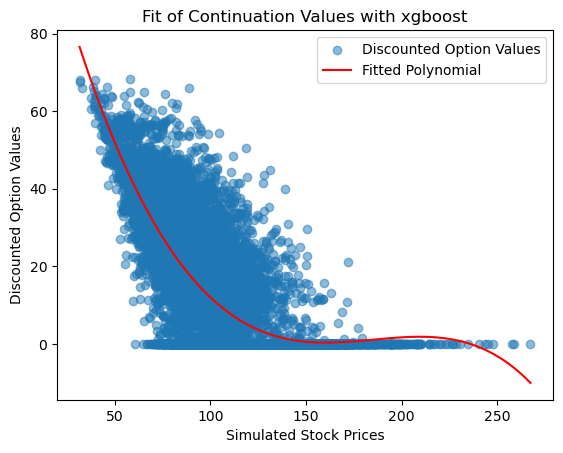

Initial Stock Price: 100, Volatility: 0.4, Maturity: 1
Simulated American (MC) Price using XGBoost: 15.8242, Standard Error: 0.1588, Time: 6.8695s


In [136]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import eval_laguerre
from math import exp, sqrt
import time
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

# Function to generate paths for the underlying asset
def paths(S0, K, T, r, sigma, M, I):
    dt = T / M
    S = np.zeros((I, M + 1))
    S[:, 0] = S0
    for t in range(1, M + 1):
        z = np.random.standard_normal(I)
        S[:, t] = S[:, t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * sqrt(dt) * z)
    return S

# Function to calculate the payoff of the option
def payoff(S, K):
    return np.maximum(K - S, 0)

# Function to calculate the discount factor
def discount_factor(r, t1, t0):
    return exp(-r * (t1 - t0))

# Longstaff-Schwartz algorithm for pricing American options using XGBoost regression
def longstaff_schwartz_xgboost(S, K, T, r, sigma, n_steps, n_paths, n_order, plot_step=None):
    dt = T / n_steps
    V = np.zeros_like(S)

    # Step 2: Set prices at maturity to the payoff
    V[:, -1] = payoff(S[:, -1], K)

    # Steps 3-8: Iterate backwards in time
    for i in range(n_steps - 1, 0, -1):
        discount = discount_factor(r, (i + 1) * dt, i * dt)
        X = S[:, i].reshape(-1, 1)
        Y = discount * V[:, i + 1]

        # Step 6a: Fit XGBoost regression model
        xgboost_model = xgb.XGBRegressor()
        xgboost_model.fit(X, Y)
        continuation_values = xgboost_model.predict(X)

        # Step 7: Exercise if immediate payoff is greater than continuation value
        immediate_payoff = payoff(S[:, i], K)
        V[:, i] = np.where(immediate_payoff > continuation_values, immediate_payoff, discount * V[:, i + 1])

        # Plot the fit at the specified time step
        if plot_step and i == plot_step:
            #plt.figure(figsize=(10, 6))
            plt.scatter(S[:, i], Y, label='Discounted Option Values', alpha=0.5)
            #plt.plot(S[:, i], continuation_values, 'r.', color='blue', label='XGBoost Continuation Values', alpha=0.5)
            
            fitted = np.polynomial.Polynomial.fit(S[:, i], Y, n_order - 1)
            plt.plot(*fitted.linspace(), color='red', label="Fitted Polynomial")

            plt.xlabel('Simulated Stock Prices')
            plt.ylabel('Discounted Option Values')
            plt.title('Fit of Continuation Values with xgboost')
            plt.legend()
            #plt.grid(True)
            plt.savefig(f'fit_plot_step_{plot_step}.png')
            plt.show()

    # Step 9-10: Calculate price today
    discounted_V = discount_factor(r, dt, 0) * V[:, 1]
    price_today = np.mean(discounted_V)
    standard_error = np.std(discounted_V) / sqrt(n_paths)
    
    return price_today, standard_error

# Parameters
K = 100  # Strike price
r = 0.02  # Risk-free interest rate
T = 1  # Time to expiration
S0 = 100  # Initial stock price
sigma = 0.4  # Volatility value
n_paths = 10000  # Number of paths
n_steps = 50  # Number of exercise points per year
n_order = 5  # Number of basis functions
plot_step = 25  # Specific time step to plot

start_time = time.time()
S = paths(S0, K, T, r, sigma, n_steps, n_paths)
price, std_err = longstaff_schwartz_xgboost(S, K, T, r, sigma, n_steps, n_paths, n_order, plot_step=plot_step)
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Initial Stock Price: {S0}, Volatility: {sigma}, Maturity: {T}")
print(f"Simulated American (MC) Price using XGBoost: {price:.4f}, Standard Error: {std_err:.4f}, Time: {elapsed_time:.4f}s")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 1
[LightGBM] [Info] Start training from score 14.862296
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 1
[LightGBM] [Info] Start training from score 14.968548
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 1
[LightGBM] [Info] Start trainin

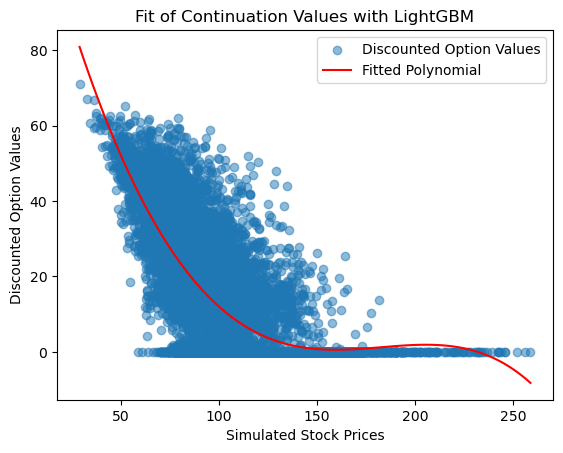

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 1
[LightGBM] [Info] Start training from score 15.643929
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 1
[LightGBM] [Info] Start training from score 15.655018
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 1
[LightGBM] [Info] Start trainin

In [137]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import eval_laguerre
from math import exp, sqrt
import time
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")
# Function to generate paths for the underlying asset
def paths(S0, K, T, r, sigma, M, I):
    dt = T / M
    S = np.zeros((I, M + 1))
    S[:, 0] = S0
    for t in range(1, M + 1):
        z = np.random.standard_normal(I)
        S[:, t] = S[:, t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * sqrt(dt) * z)
    return S

# Function to calculate the payoff of the option
def payoff(S, K):
    return np.maximum(K - S, 0)

# Function to calculate the discount factor
def discount_factor(r, t1, t0):
    return exp(-r * (t1 - t0))

# Longstaff-Schwartz algorithm for pricing American options using LightGBM regression
def longstaff_schwartz_lgbm(S, K, T, r, sigma, n_steps, n_paths, n_order, plot_step=None):
    dt = T / n_steps
    V = np.zeros_like(S)

    # Step 2: Set prices at maturity to the payoff
    V[:, -1] = payoff(S[:, -1], K)

    # Steps 3-8: Iterate backwards in time
    for i in range(n_steps - 1, 0, -1):
        discount = discount_factor(r, (i + 1) * dt, i * dt)
        X = S[:, i].reshape(-1, 1)
        Y = discount * V[:, i + 1]

        # Step 6a: Fit LightGBM regression model
        lgbm_model = lgb.LGBMRegressor()
        lgbm_model.fit(X, Y)
        continuation_values = lgbm_model.predict(X)

        # Step 7: Exercise if immediate payoff is greater than continuation value
        immediate_payoff = payoff(S[:, i], K)
        V[:, i] = np.where(immediate_payoff > continuation_values, immediate_payoff, discount * V[:, i + 1])

        # Plot the fit at the specified time step
        if plot_step and i == plot_step:
            #plt.figure(figsize=(10, 6))
            plt.scatter(S[:, i], Y, label='Discounted Option Values', alpha=0.5)
            #plt.plot(S[:, i], continuation_values, 'r.', color='blue', label='LightGBM Continuation Values', alpha=0.5)
            
            fitted = np.polynomial.Polynomial.fit(S[:, i], Y, n_order - 1)
            plt.plot(*fitted.linspace(), color='red', label="Fitted Polynomial")

            plt.xlabel('Simulated Stock Prices')
            plt.ylabel('Discounted Option Values')
            plt.title('Fit of Continuation Values with LightGBM')
            plt.legend()
            #plt.grid(True)
            #plt.savefig(f'fit_plot_step_{plot_step}.png')
            plt.show()

    # Step 9-10: Calculate price today
    discounted_V = discount_factor(r, dt, 0) * V[:, 1]
    price_today = np.mean(discounted_V)
    standard_error = np.std(discounted_V) / sqrt(n_paths)
    
    return price_today, standard_error

# Parameters
K = 100  # Strike price
r = 0.02  # Risk-free interest rate
T = 1  # Time to expiration
S0 = 100  # Initial stock price
sigma = 0.4  # Volatility value
n_paths = 10000  # Number of paths
n_steps = 50  # Number of exercise points per year
n_order = 5  # Number of basis functions
plot_step = 25  # Specific time step to plot

start_time = time.time()
S = paths(S0, K, T, r, sigma, n_steps, n_paths)
price, std_err = longstaff_schwartz_lgbm(S, K, T, r, sigma, n_steps, n_paths, n_order, plot_step=plot_step)
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Initial Stock Price: {S0}, Volatility: {sigma}, Maturity: {T}")
print(f"Simulated American (MC) Price using LightGBM: {price:.4f}, Standard Error: {std_err:.4f}, Time: {elapsed_time:.4f}s")


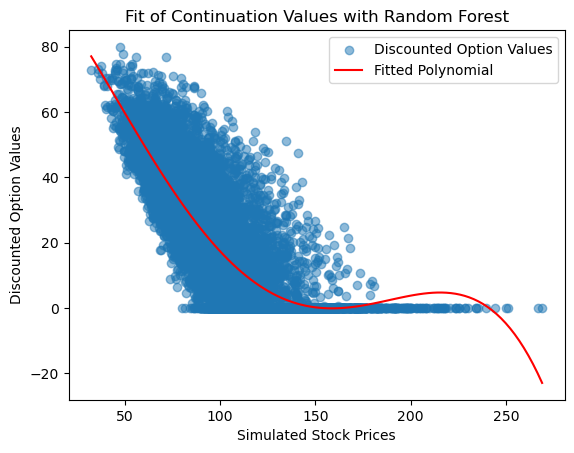

Initial Stock Price: 100, Volatility: 0.4, Maturity: 1
Simulated American (MC) Price using Random Forest: 23.3122, Standard Error: 0.1752, Time: 167.0952s


In [138]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import eval_laguerre
from math import exp, sqrt
import time
from sklearn.ensemble import RandomForestRegressor

# Function to generate paths for the underlying asset
def paths(S0, K, T, r, sigma, M, I):
    dt = T / M
    S = np.zeros((I, M + 1))
    S[:, 0] = S0
    for t in range(1, M + 1):
        z = np.random.standard_normal(I)
        S[:, t] = S[:, t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * sqrt(dt) * z)
    return S

# Function to calculate the payoff of the option
def payoff(S, K):
    return np.maximum(K - S, 0)

# Function to calculate the discount factor
def discount_factor(r, t1, t0):
    return exp(-r * (t1 - t0))

# Longstaff-Schwartz algorithm for pricing American options using Random Forest regression
def longstaff_schwartz_rf(S, K, T, r, sigma, n_steps, n_paths, n_order, plot_step=None):
    dt = T / n_steps
    V = np.zeros_like(S)

    # Step 2: Set prices at maturity to the payoff
    V[:, -1] = payoff(S[:, -1], K)

    # Steps 3-8: Iterate backwards in time
    for i in range(n_steps - 1, 0, -1):
        discount = discount_factor(r, (i + 1) * dt, i * dt)
        X = S[:, i].reshape(-1, 1)
        Y = discount * V[:, i + 1]

        # Step 6a: Fit Random Forest regression model
        rf_model = RandomForestRegressor(n_estimators=100)
        rf_model.fit(X, Y)
        continuation_values = rf_model.predict(X)

        # Step 7: Exercise if immediate payoff is greater than continuation value
        immediate_payoff = payoff(S[:, i], K)
        V[:, i] = np.where(immediate_payoff > continuation_values, immediate_payoff, discount * V[:, i + 1])

        # Plot the fit at the specified time step
        if plot_step and i == plot_step:
            #plt.figure(figsize=(10, 6))
            plt.scatter(S[:, i], Y, label='Discounted Option Values', alpha=0.5)
            #plt.plot(S[:, i], continuation_values, 'r.', color='blue', label='Random Forest Continuation Values', alpha=0.5)
            
            fitted = np.polynomial.Polynomial.fit(S[:, i], Y, n_order - 1)
            plt.plot(*fitted.linspace(), color='red', label="Fitted Polynomial")

            plt.xlabel('Simulated Stock Prices')
            plt.ylabel('Discounted Option Values')
            plt.title('Fit of Continuation Values with Random Forest')
            plt.legend()
            #plt.grid(True)
            #plt.savefig(f'fit_plot_step_{plot_step}.png')
            plt.show()

    # Step 9-10: Calculate price today
    discounted_V = discount_factor(r, dt, 0) * V[:, 1]
    price_today = np.mean(discounted_V)
    standard_error = np.std(discounted_V) / sqrt(n_paths)
    
    return price_today, standard_error

# Parameters
K = 100  # Strike price
r = 0.02  # Risk-free interest rate
T = 1  # Time to expiration
S0 = 100  # Initial stock price
sigma = 0.4  # Volatility value
n_paths = 10000  # Number of paths
n_steps = 50  # Number of exercise points per year
n_order = 5  # Number of basis functions
plot_step = 25  # Specific time step to plot

start_time = time.time()
S = paths(S0, K, T, r, sigma, n_steps, n_paths)
price, std_err = longstaff_schwartz_rf(S, K, T, r, sigma, n_steps, n_paths, n_order, plot_step=plot_step)
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Initial Stock Price: {S0}, Volatility: {sigma}, Maturity: {T}")
print(f"Simulated American (MC) Price using Random Forest: {price:.4f}, Standard Error: {std_err:.4f}, Time: {elapsed_time:.4f}s")


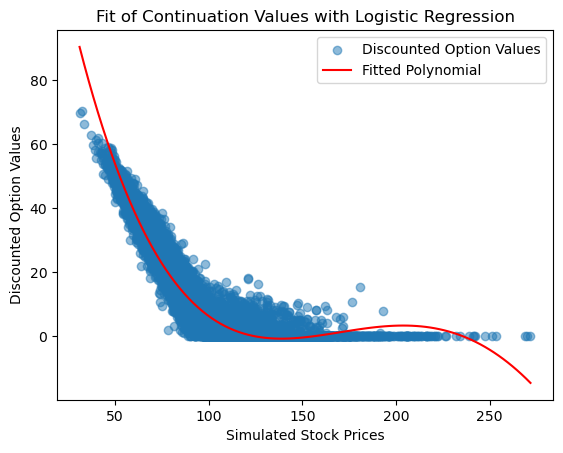

Initial Stock Price: 100, Volatility: 0.4, Maturity: 1
Simulated American (MC) Price using Logistic Regression: 4.1614, Standard Error: 0.0311, Time: 2.1332s


In [139]:
import numpy as np
import matplotlib.pyplot as plt
from math import exp, sqrt
import time
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.special import expit
import warnings
warnings.filterwarnings("ignore")

# Function to generate paths for the underlying asset
def paths(S0, K, T, r, sigma, M, I):
    dt = T / M
    S = np.zeros((I, M + 1))
    S[:, 0] = S0
    for t in range(1, M + 1):
        z = np.random.standard_normal(I)
        S[:, t] = S[:, t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * sqrt(dt) * z)
    return S

# Function to calculate the payoff of the option
def payoff(S, K):
    return np.maximum(K - S, 0)

# Function to calculate the discount factor
def discount_factor(r, t1, t0):
    return exp(-r * (t1 - t0))

# Longstaff-Schwartz algorithm for pricing American options using Logistic Regression
def longstaff_schwartz_logreg(S, K, T, r, sigma, n_steps, n_paths, n_order, plot_step=None):
    dt = T / n_steps
    V = np.zeros_like(S)

    # Step 2: Set prices at maturity to the payoff
    V[:, -1] = payoff(S[:, -1], K)

    # Steps 3-8: Iterate backwards in time
    for i in range(n_steps - 1, 0, -1):
        discount = discount_factor(r, (i + 1) * dt, i * dt)
        X = S[:, i].reshape(-1, 1)
        Y = discount * V[:, i + 1]

        # Step 6a: Fit Logistic Regression model with polynomial features
        poly = PolynomialFeatures(degree=n_order - 1)
        X_poly = poly.fit_transform(X)
        logreg_model = LogisticRegression()
        logreg_model.fit(X_poly, (Y > 0).astype(int))
        continuation_values_normalized = logreg_model.predict_proba(X_poly)[:, 1]
        continuation_values = expit(continuation_values_normalized)

        # Step 7: Exercise if immediate payoff is greater than continuation value
        immediate_payoff = payoff(S[:, i], K)
        V[:, i] = np.where(immediate_payoff > continuation_values, immediate_payoff, discount * V[:, i + 1])

        # Plot the fit at the specified time step
        if plot_step and i == plot_step:
            #plt.figure(figsize=(10, 6))
            plt.scatter(S[:, i], Y, label='Discounted Option Values', alpha=0.5)
            #plt.plot(S[:, i], continuation_values, 'r.', label='Logistic Regression Continuation Values', alpha=0.5)
            
            fitted = np.polynomial.Polynomial.fit(S[:, i], Y, n_order - 1)
            plt.plot(*fitted.linspace(), color='red', label="Fitted Polynomial")

            plt.xlabel('Simulated Stock Prices')
            plt.ylabel('Discounted Option Values')
            plt.title('Fit of Continuation Values with Logistic Regression')
            plt.legend()
            #plt.grid(True)
            plt.show()

    # Step 9-10: Calculate price today
    discounted_V = discount_factor(r, dt, 0) * V[:, 1]
    price_today = np.mean(discounted_V)
    standard_error = np.std(discounted_V) / sqrt(n_paths)
    
    return price_today, standard_error

# Parameters
K = 100  # Strike price
r = 0.02  # Risk-free interest rate
T = 1  # Time to expiration
S0 = 100  # Initial stock price
sigma = 0.4  # Volatility value
n_paths = 10000  # Number of paths
n_steps = 50  # Number of exercise points per year
n_order = 5  # Number of basis functions
plot_step = 25  # Specific time step to plot

start_time = time.time()
S = paths(S0, K, T, r, sigma, n_steps, n_paths)
price, std_err = longstaff_schwartz_logreg(S, K, T, r, sigma, n_steps, n_paths, n_order, plot_step=plot_step)
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Initial Stock Price: {S0}, Volatility: {sigma}, Maturity: {T}")
print(f"Simulated American (MC) Price using Logistic Regression: {price:.4f}, Standard Error: {std_err:.4f}, Time: {elapsed_time:.4f}s")


## MODELS AND ITS EVALUATION

Running LSM with KNN...
Model: KNN
Price: 18.9999, Standard Error: 0.1646, Time: 1.1151s
Accuracy: 0.5101, AUC: 0.6677, PR-AUC: 0.6588, Precision: 0.5090, Recall: 1.0000, F1-Score: 0.6746


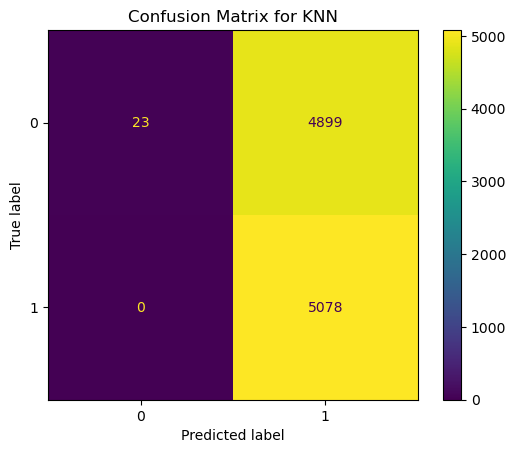

Running LSM with Decision Tree...
Model: Decision Tree
Price: 24.8694, Standard Error: 0.1682, Time: 2.8941s
Accuracy: 0.5599, AUC: 0.6041, PR-AUC: 0.5813, Precision: 0.5370, Recall: 0.9663, F1-Score: 0.6904


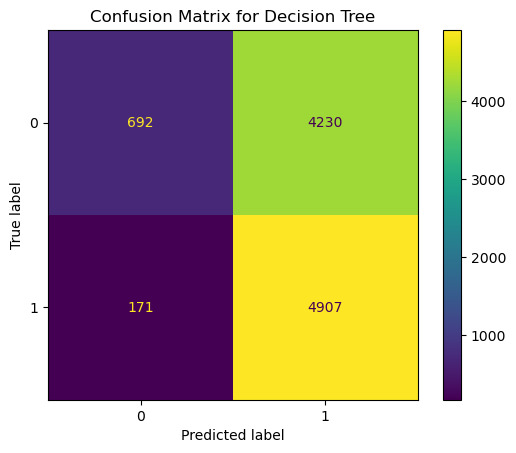

Running LSM with XGBoost...
Model: XGBoost
Price: 15.9998, Standard Error: 0.1565, Time: 8.8602s
Accuracy: 0.5078, AUC: 0.8416, PR-AUC: 0.8425, Precision: 0.5078, Recall: 1.0000, F1-Score: 0.6736


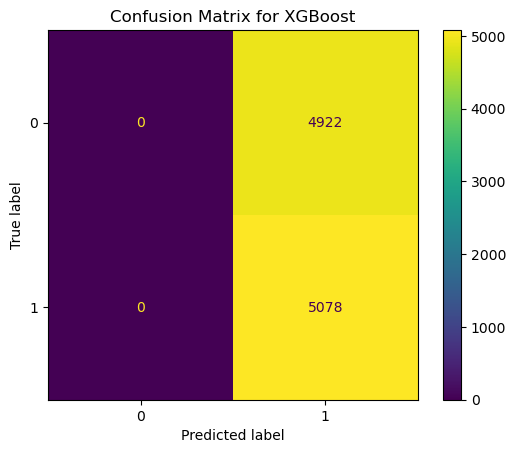

Running LSM with LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 1
[LightGBM] [Info] Start training from score 15.195811
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 1
[LightGBM] [Info] Start training from score 15.309308
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of da

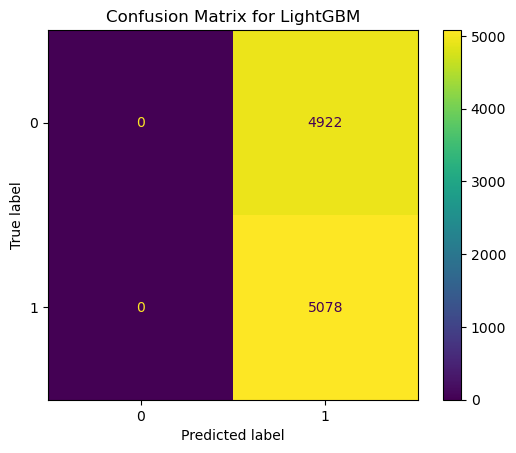

Running LSM with Logistic Regression...
Model: Logistic Regression
Price: 14.9009, Standard Error: 0.1785, Time: 17.5270s
Accuracy: 0.9995, AUC: 1.0000, PR-AUC: 1.0000, Precision: 0.9990, Recall: 1.0000, F1-Score: 0.9995


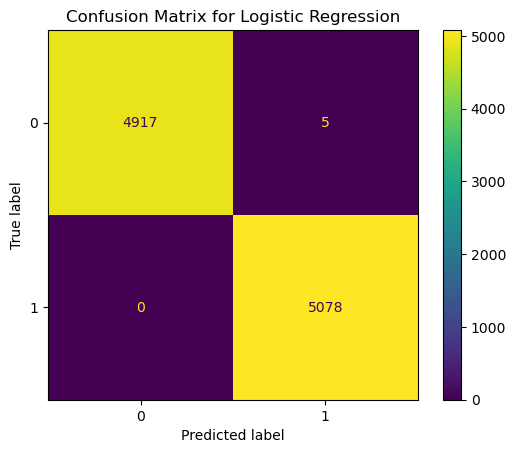

Running LSM with Random Forest...
Model: Random Forest
Price: 23.4676, Standard Error: 0.1740, Time: 181.6655s
Accuracy: 0.5111, AUC: 0.6332, PR-AUC: 0.6174, Precision: 0.5095, Recall: 1.0000, F1-Score: 0.6750


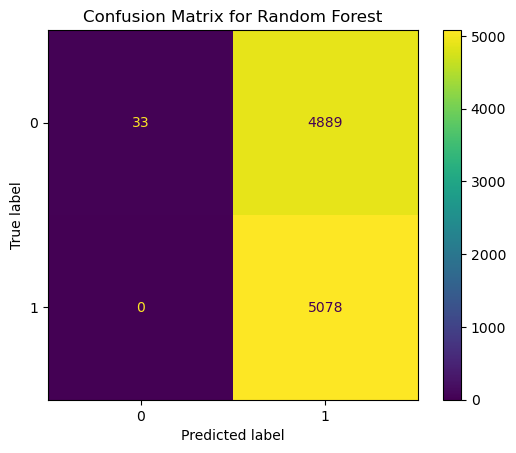

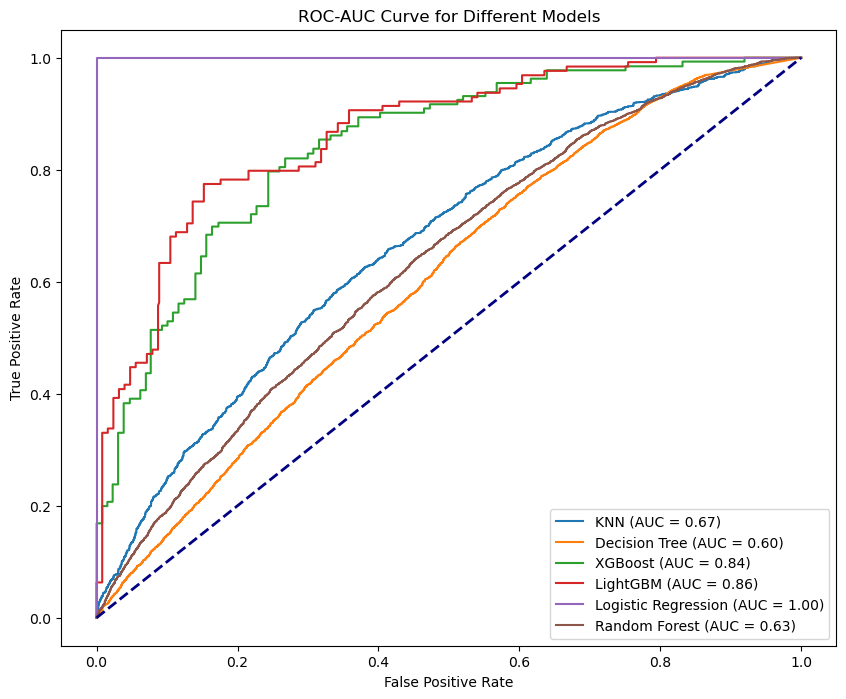

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from math import exp, sqrt
import time
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, f1_score, 
    accuracy_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
)
import warnings
warnings.filterwarnings("ignore")

# Function to generate paths for the underlying asset
def paths(S0, K, T, r, sigma, M, I):
    dt = T / M
    S = np.zeros((I, M + 1))
    S[:, 0] = S0
    for t in range(1, M + 1):
        z = np.random.standard_normal(I)
        S[:, t] = S[:, t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * sqrt(dt) * z)
    return S

# Function to calculate the payoff of the option
def payoff(S, K):
    return np.maximum(K - S, 0)

# Function to calculate the discount factor
def discount_factor(r, t1, t0):
    return exp(-r * (t1 - t0))

# Longstaff-Schwartz algorithm for pricing American options using various models
def longstaff_schwartz_ml(S, K, T, r, sigma, n_steps, n_paths, model, n_order=n_order, is_logistic=False, plot_step=plot_step):
    dt = T / n_steps
    V = np.zeros_like(S)

    # Set prices at maturity to the payoff
    V[:, -1] = payoff(S[:, -1], K)

    for i in range(n_steps - 1, 0, -1):
        discount = discount_factor(r, (i + 1) * dt, i * dt)
        X = S[:, i].reshape(-1, 1)
        Y = discount * V[:, i + 1]

        if is_logistic:
            poly = PolynomialFeatures(degree=n_order - 1)
            pipeline = make_pipeline(poly, StandardScaler(), LogisticRegression(C=1.0, max_iter=10000))
            pipeline.fit(X, (Y > 0).astype(int))
            continuation_values_normalized = pipeline.predict_proba(X)[:, 1]
            continuation_values = continuation_values_normalized * K
        else:
            model.fit(X, Y)
            continuation_values = model.predict(X)

        immediate_payoff = payoff(S[:, i], K)
        V[:, i] = np.where(immediate_payoff > continuation_values, immediate_payoff, discount * V[:, i + 1])

    discounted_V = discount_factor(r, dt, 0) * V[:, 1]
    price_today = np.mean(discounted_V)
    standard_error = np.std(discounted_V) / sqrt(n_paths)

    return price_today, standard_error

# Parameters
K = 100
r = 0.02
T = 1
S0 = 100
sigma = 0.4
n_paths = 10000
n_steps = 50
n_order = 5
plot_step = 25

start_time = time.time()
S = paths(S0, K, T, r, sigma, n_steps, n_paths)

models = {
    "KNN": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "XGBoost": XGBRegressor(),
    "LightGBM": LGBMRegressor(),
    "Logistic Regression": LogisticRegression(max_iter=10000),
    "Random Forest": RandomForestRegressor()
}

results = {}
roc_auc = {}
pr_auc = {}
evaluation_metrics = {}

for name, model in models.items():
    print(f"Running LSM with {name}...")
    if name == "Logistic Regression":
        price, std_err = longstaff_schwartz_ml(S, K, T, r, sigma, n_steps, n_paths, model, n_order=n_order, is_logistic=True, plot_step=plot_step)
    else:
        price, std_err = longstaff_schwartz_ml(S, K, T, r, sigma, n_steps, n_paths, model, plot_step=plot_step)
    results[name] = (price, std_err)
    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f"Model: {name}")
    print(f"Price: {price:.4f}, Standard Error: {std_err:.4f}, Time: {elapsed_time:.4f}s")

    # Calculate evaluation metrics
    y_true = payoff(S[:, 1], K) > 0
    if name == "Logistic Regression":
        poly = PolynomialFeatures(degree=n_order - 1)
        pipeline = make_pipeline(poly, StandardScaler(), LogisticRegression(C=1.0, max_iter=10000))
        pipeline.fit(S[:, 1].reshape(-1, 1), y_true.astype(int))
        y_scores = pipeline.predict_proba(S[:, 1].reshape(-1, 1))[:, 1]
    else:
        y_scores = model.predict(S[:, 1].reshape(-1, 1))
    
    roc_auc[name] = roc_auc_score(y_true, y_scores)
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    pr_auc[name] = auc(recall, precision)
    precision = precision_score(y_true, y_scores > 0.5)
    recall = recall_score(y_true, y_scores > 0.5)
    f1 = f1_score(y_true, y_scores > 0.5)
    accuracy = accuracy_score(y_true, y_scores > 0.5)

    evaluation_metrics[name] = {
        "Accuracy": accuracy,
        "AUC": roc_auc[name],
        "PR-AUC": pr_auc[name],
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    }

    print(f"Accuracy: {accuracy:.4f}, AUC: {roc_auc[name]:.4f}, PR-AUC: {pr_auc[name]:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    # Plot Confusion Matrix
    cm = confusion_matrix(y_true, y_scores > 0.5)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

# Plot ROC-AUC curves
plt.figure(figsize=(10, 8))
for name, model in models.items():
    if name == "Logistic Regression":
        y_scores = pipeline.predict_proba(S[:, 1].reshape(-1, 1))[:, 1]
    else:
        y_scores = model.predict(S[:, 1].reshape(-1, 1))
    fpr, tpr, _ = roc_curve(payoff(S[:, 1], K) > 0, y_scores)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc[name]:.2f})')

plt.xlabel('False Positive Rate')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve for Different Models')
plt.legend()
plt.show()


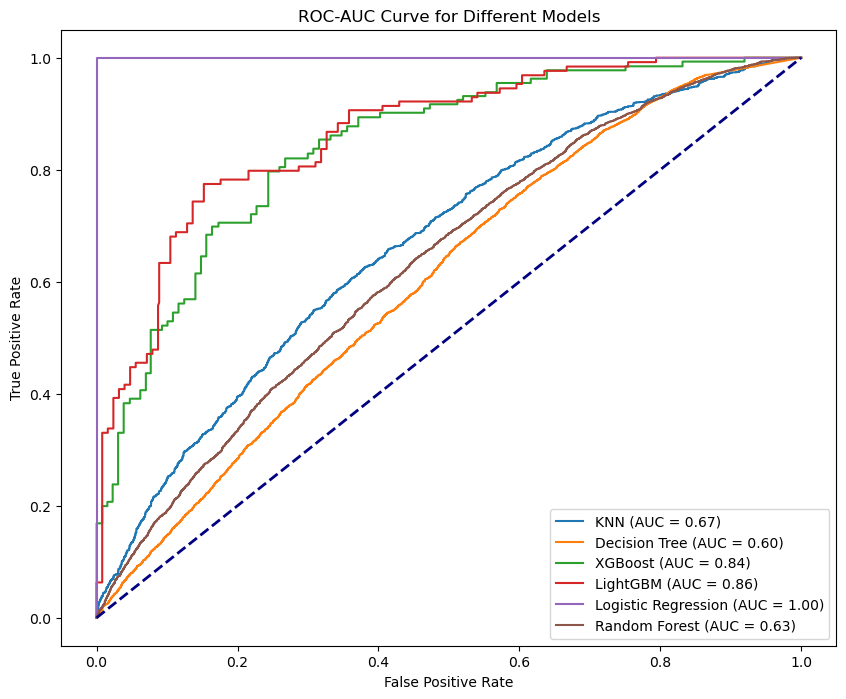

In [19]:
# Plot ROC-AUC curves
plt.figure(figsize=(10, 8))
for name, model in models.items():
    if name == "Logistic Regression":
        y_scores = pipeline.predict_proba(S[:, 1].reshape(-1, 1))[:, 1]
    else:
        y_scores = model.predict(S[:, 1].reshape(-1, 1))
    fpr, tpr, _ = roc_curve(payoff(S[:, 1], K) > 0, y_scores)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc[name]:.2f})')

plt.xlabel('False Positive Rate')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve for Different Models')
plt.legend()
plt.show()

Running LSM with KNN...
Model: KNN
Price: 18.7514, Standard Error: 0.1633, Time: 1.0819s
Accuracy: 0.5136, AUC: 0.6646, PR-AUC: 0.6575, Precision: 0.5128, Recall: 1.0000, F1-Score: 0.6780


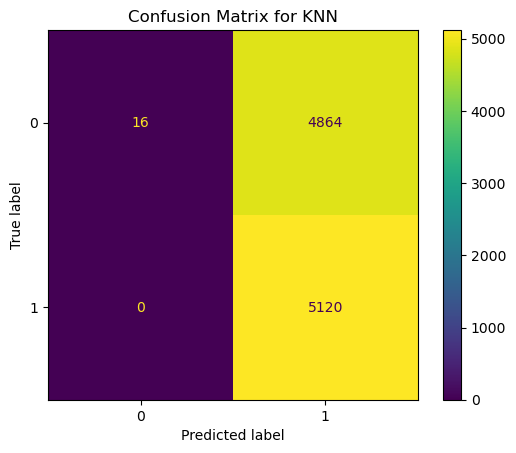

Running LSM with Decision Tree...
Model: Decision Tree
Price: 24.6791, Standard Error: 0.1678, Time: 2.9121s
Accuracy: 0.5663, AUC: 0.6045, PR-AUC: 0.5865, Precision: 0.5429, Recall: 0.9680, F1-Score: 0.6956


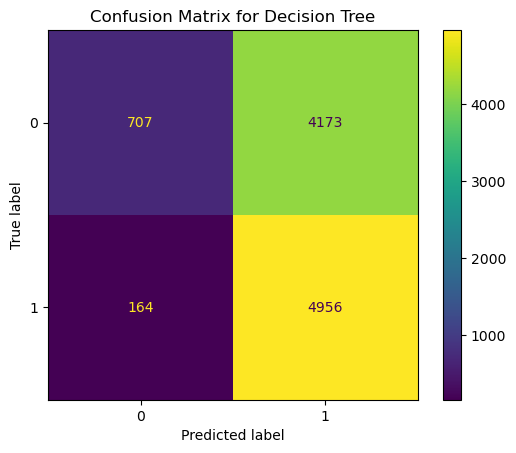

Running LSM with XGBoost...
Model: XGBoost
Price: 15.7592, Standard Error: 0.1545, Time: 9.1730s
Accuracy: 0.5120, AUC: 0.8570, PR-AUC: 0.8479, Precision: 0.5120, Recall: 1.0000, F1-Score: 0.6772


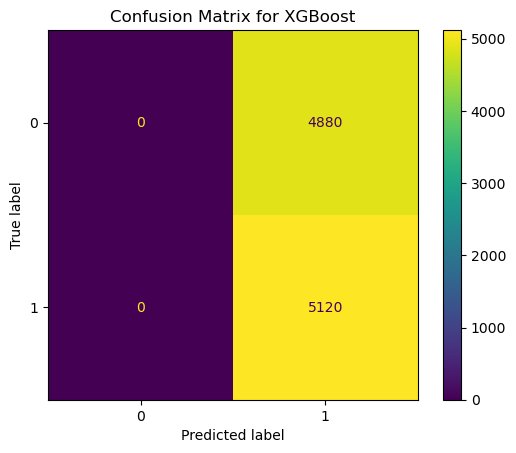

Running LSM with LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 1
[LightGBM] [Info] Start training from score 14.838316
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 1
[LightGBM] [Info] Start training from score 14.954600
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of da

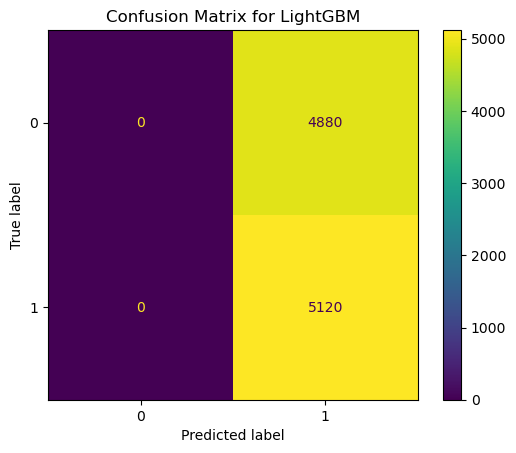

Running LSM with Logistic Regression...
Model: Logistic Regression
Price: 14.5503, Standard Error: 0.1771, Time: 17.7765s
Accuracy: 0.9937, AUC: 1.0000, PR-AUC: 1.0000, Precision: 0.9878, Recall: 1.0000, F1-Score: 0.9939


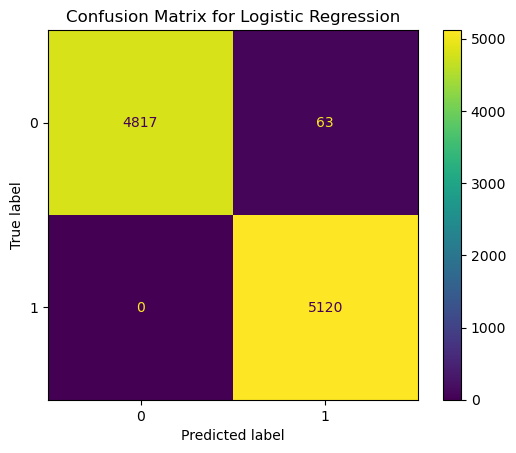

Running LSM with Random Forest...
Model: Random Forest
Price: 23.2354, Standard Error: 0.1740, Time: 182.3978s
Accuracy: 0.5142, AUC: 0.6344, PR-AUC: 0.6176, Precision: 0.5131, Recall: 0.9998, F1-Score: 0.6782


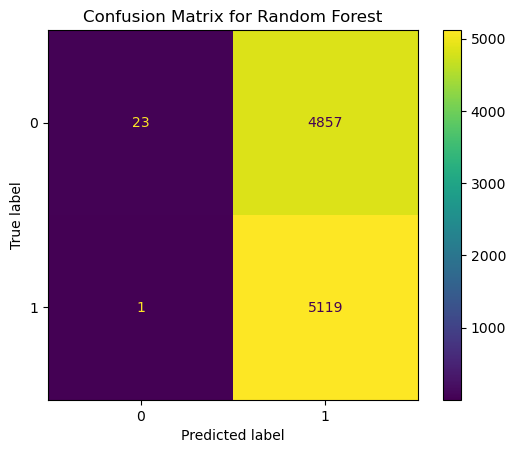

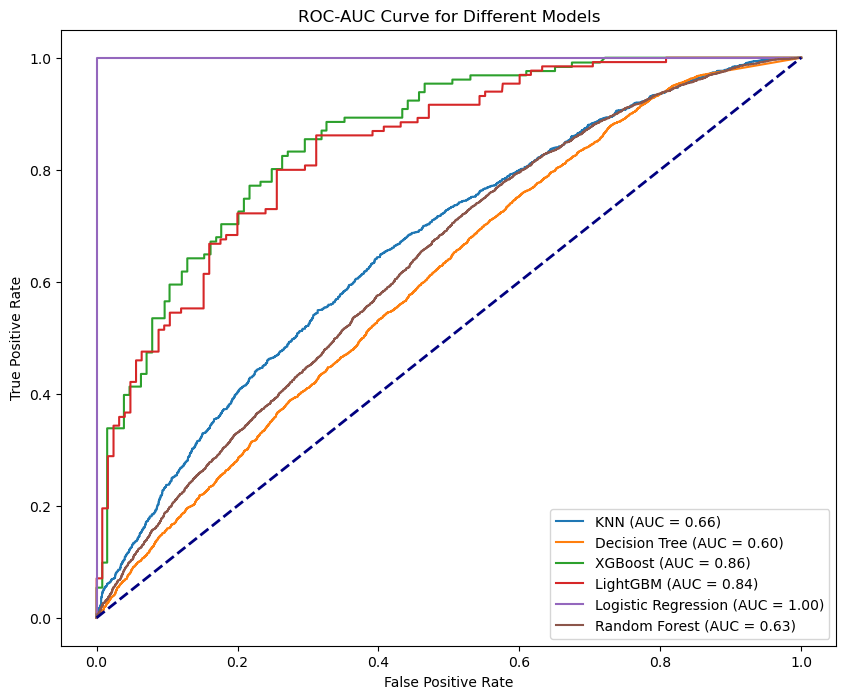

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from math import exp, sqrt
import time
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, f1_score, 
    accuracy_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
)
import warnings
warnings.filterwarnings("ignore")

# Function to generate paths for the underlying asset
def paths(S0, K, T, r, sigma, M, I):
    dt = T / M
    S = np.zeros((I, M + 1))
    S[:, 0] = S0
    for t in range(1, M + 1):
        z = np.random.standard_normal(I)
        S[:, t] = S[:, t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * sqrt(dt) * z)
    return S

# Function to calculate the payoff of the option
def payoff(S, K):
    return np.maximum(K - S, 0)

# Function to calculate the discount factor
def discount_factor(r, t1, t0):
    return exp(-r * (t1 - t0))

# Longstaff-Schwartz algorithm for pricing American options using various models
def longstaff_schwartz_ml(S, K, T, r, sigma, n_steps, n_paths, model, n_order=5, is_logistic=False, plot_step=25):
    dt = T / n_steps
    V = np.zeros_like(S)

    # Set prices at maturity to the payoff
    V[:, -1] = payoff(S[:, -1], K)

    for i in range(n_steps - 1, 0, -1):
        discount = discount_factor(r, (i + 1) * dt, i * dt)
        X = S[:, i].reshape(-1, 1)
        Y = discount * V[:, i + 1]

        if is_logistic:
            poly = PolynomialFeatures(degree=n_order - 1)
            pipeline = make_pipeline(poly, StandardScaler(), LogisticRegression(C=0.01, penalty='l2', solver='liblinear', max_iter=10000))
            pipeline.fit(X, (Y > 0).astype(int))
            continuation_values_normalized = pipeline.predict_proba(X)[:, 1]
            continuation_values = continuation_values_normalized * K
        else:
            model.fit(X, Y)
            continuation_values = model.predict(X)

        immediate_payoff = payoff(S[:, i], K)
        V[:, i] = np.where(immediate_payoff > continuation_values, immediate_payoff, discount * V[:, i + 1])

    discounted_V = discount_factor(r, dt, 0) * V[:, 1]
    price_today = np.mean(discounted_V)
    standard_error = np.std(discounted_V) / sqrt(n_paths)

    return price_today, standard_error

# Parameters
K = 100
r = 0.02
T = 1
S0 = 100
sigma = 0.4
n_paths = 10000
n_steps = 50
n_order = 5
plot_step = 25

start_time = time.time()
S = paths(S0, K, T, r, sigma, n_steps, n_paths)

models = {
    "KNN": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "XGBoost": XGBRegressor(),
    "LightGBM": LGBMRegressor(),
    "Logistic Regression": LogisticRegression(max_iter=10000),
    "Random Forest": RandomForestRegressor()
}

results = {}
roc_auc = {}
pr_auc = {}
evaluation_metrics = {}

for name, model in models.items():
    print(f"Running LSM with {name}...")
    if name == "Logistic Regression":
        price, std_err = longstaff_schwartz_ml(S, K, T, r, sigma, n_steps, n_paths, model, n_order=n_order, is_logistic=True, plot_step=plot_step)
    else:
        price, std_err = longstaff_schwartz_ml(S, K, T, r, sigma, n_steps, n_paths, model, plot_step=plot_step)
    results[name] = (price, std_err)
    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f"Model: {name}")
    print(f"Price: {price:.4f}, Standard Error: {std_err:.4f}, Time: {elapsed_time:.4f}s")

    # Calculate evaluation metrics
    y_true = payoff(S[:, 1], K) > 0
    if name == "Logistic Regression":
        poly = PolynomialFeatures(degree=n_order - 1)
        pipeline = make_pipeline(poly, StandardScaler(), LogisticRegression(C=0.01, penalty='l2', solver='liblinear', max_iter=10000))
        pipeline.fit(S[:, 1].reshape(-1, 1), y_true.astype(int))
        y_scores = pipeline.predict_proba(S[:, 1].reshape(-1, 1))[:, 1]
    else:
        y_scores = model.predict(S[:, 1].reshape(-1, 1))
    
    roc_auc[name] = roc_auc_score(y_true, y_scores)
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    pr_auc[name] = auc(recall, precision)
    precision = precision_score(y_true, y_scores > 0.5)
    recall = recall_score(y_true, y_scores > 0.5)
    f1 = f1_score(y_true, y_scores > 0.5)
    accuracy = accuracy_score(y_true, y_scores > 0.5)

    evaluation_metrics[name] = {
        "Accuracy": accuracy,
        "AUC": roc_auc[name],
        "PR-AUC": pr_auc[name],
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    }

    print(f"Accuracy: {accuracy:.4f}, AUC: {roc_auc[name]:.4f}, PR-AUC: {pr_auc[name]:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    # Plot Confusion Matrix
    cm = confusion_matrix(y_true, y_scores > 0.5)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

# Plot ROC-AUC curves
plt.figure(figsize=(10, 8))
for name, model in models.items():
    if name == "Logistic Regression":
        y_scores = pipeline.predict_proba(S[:, 1].reshape(-1, 1))[:, 1]
    else:
        y_scores = model.predict(S[:, 1].reshape(-1, 1))
    fpr, tpr, _ = roc_curve(payoff(S[:, 1], K) > 0, y_scores)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc[name]:.2f})')

plt.xlabel('False Positive Rate')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve for Different Models')
plt.legend()
plt.show()
